In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
#from torch.utils import data
from fastai.vision import *
import warnings
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
from fastai3D import loader #does not comply 
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
#path = untar_data(URLs.CAMVID_TINY)#small segmentation test set
#path_img = path/'images' #should later be provided through ini file
#path_lbl = path/'labels' #should later be provided through ini file
#path.ls()
#parts = np.loadtxt(path/'codes.txt', dtype=str); parts #should later be provided through ini file
#these setting should later be set through an ini file
#bs = 4 #batch size, set smaller when running out of memory
#get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [5]:
#Data Block API
#data = SegmentationItemList.from_folder(path_img).split_by_rand_pct(valid_pct=0.2, seed=42) #for seed validation use an unseen kernel? because slices are not independent of eachother (like video)
#data = data.label_from_func(get_y_fn, classes=parts)
#data = data.transform(get_transforms(), tfm_y=True, size=128) #for the seeds set get_transforms(flip_vert:bool=True) and perhaps something with max_rotate()
#data = data.databunch(bs=bs, path=path)
#data = data.normalize() #think about this for the seeds
#data

In [6]:
#Have a quick look at the data (optional)
#data.show_batch(rows=2, figsize=(7,5))
#learn = unet_learner(data, models.resnet18) #think of other arguments to pass, such as custom defined metrics
#learn.fit_one_cycle(cyc_len=10, max_lr=1e-2) #what other argumenets should be passed in? how many epochs? what lr
#learn.show_results()

##Seed Data

In [7]:
path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train')
path_img = path/'Images' #should later be provided through ini file
path_lbl = path/'Labels' #should later be provided through ini file
classes = range(4)

def get_mask(img):
    return (path_lbl)/img.name

In [8]:
"""function to filter out images that only contain background; used to filter in the data block API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

In [9]:
data = SegmentationItemList.from_folder(path).filter_by_func(check_back).split_by_fname_file('valid.txt')

In [10]:
data = data.label_from_func(get_mask, classes=classes)

In [11]:
data = data.transform(get_transforms(flip_vert=True), tfm_y=True, size=128)

In [12]:
data = data.databunch(bs=1)

In [13]:
data = data.normalize()

In [14]:
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), 2, True))

In [15]:
data.batch_size

2

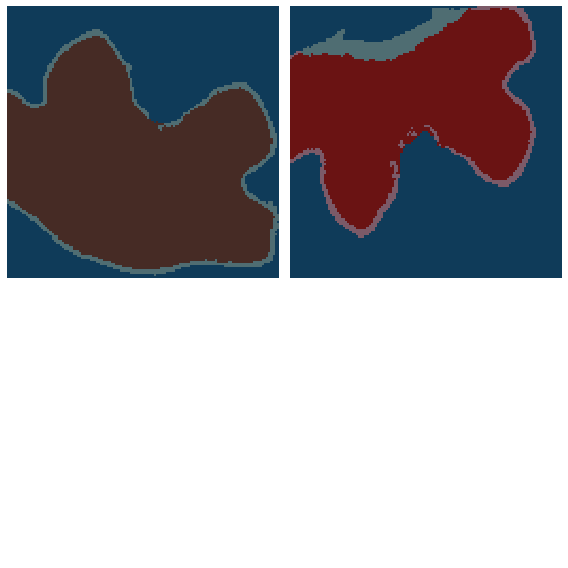

In [16]:
data.show_batch(4)

Seed data to Learner

In [17]:
def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [18]:
metrics=acc_seeds
wd=1e-2
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


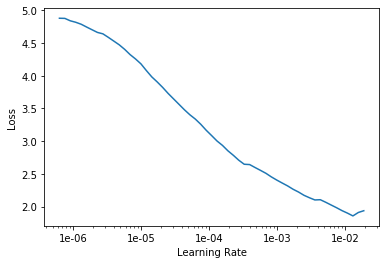

In [19]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(cyc_len=1, max_lr=3e-4)

epoch,train_loss,valid_loss,acc_seeds,time
0,0.059203,0.336764,0.296388,13:18


In [21]:
learn_output = learn.data
learn_batch = learn_output.one_batch()
learn_batch[0].size()

torch.Size([2, 3, 128, 128])

In [22]:
a_batch = data.one_batch(detach=True)
a_batch
a_batch[0].size()

torch.Size([2, 3, 128, 128])

In [23]:
img1 = torch.Tensor(a_batch[0][0])
img2 = torch.Tensor(a_batch[0][1])
img1.size()

torch.Size([3, 128, 128])

In [24]:
two_img = img1
two_img = torch.stack((img1, img2), dim = 3)
two_img.unsqueeze_(0)
two_img.size()


torch.Size([1, 3, 128, 128, 2])

In [25]:
from torch import nn

In [26]:
simple_3conv = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(1,1,1), stride=1, padding=0)
#input = torch.randn(1,3 , 6, 10, 10)
#print(input)
#output = simple_3conv(input)
#output.size()
#torch.Size([1, 30, 3, 10, 10])
simple_2conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=1, padding=0)

In [27]:
output = simple_2conv(a_batch[0])
output.size()

torch.Size([2, 64, 126, 126])

In [28]:
output3 = simple_3conv(two_img)
output3.size()

torch.Size([1, 64, 128, 128, 2])

In [29]:
from fastai.layers import *
my_conv_layer1 = conv_layer(3, 64)
my_conv_layer2 = conv_layer(64,128)
con_test = my_conv_layer2(my_conv_layer1(a_batch[0]))

In [30]:
con_test.size()

torch.Size([2, 128, 128, 128])

In [37]:
#con_test

In [32]:
my_conv_layer1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [35]:
this_relu = relu(leaky=None)
this_relu

ReLU()

In [63]:
def conv3_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               is_2d:bool = False, trans_2d:bool = False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose3d if transpose else nn.Conv1d if is_1d else nn.ConvTranspose2d if trans_2d else nn.Conv2d if is_2d else nn.Conv3d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d if is_2d else nn.BatchNorm3d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [70]:
my_conv_layer1 = conv_layer(3, 64)
my_conv_layer2 = conv_layer(64,128)
con_test = my_conv_layer2(my_conv_layer1(a_batch[0]))

In [65]:
my_conv_layer1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [47]:
#con_test

In [46]:
con_test.size()

torch.Size([2, 128, 128, 128])

In [71]:
my_3conv_l1 = conv3_layer(3,64)
my_3conv_l2 = conv3_layer(64,128)
con3_test= my_3conv_l2(my_3conv_l1(two_img))

In [72]:
con3_test.size()

torch.Size([1, 128, 128, 128, 2])

In [73]:
from fastai.vision.models.unet import *
from fastai.callbacks.hooks import *
class Unet3Block(Module):
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv3_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv3_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)
        
    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))


In [ ]:
#test Unet3Block
unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa, **kwargs).eval()

In [62]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class Dynamic3DUnet(SequentialEx):
    "Create a volumetric U-Net from a given architecture. Completely based of the Dynamic Unet from fastai."
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv3_layer(ni, ni*2, **kwargs),
                                    conv3_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()